# Data Input+ PRocessing

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt
import keras
import tensorflow.keras as K
import tensorflow.keras.backend as Kback

from keras import layers
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet50
from keras.applications import vgg16
from keras.applications import inception_v3
from keras.src.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import DenseNet121, NASNetMobile, EfficientNetB0, Xception
from keras.layers import GlobalAveragePooling2D
from keras.applications.densenet import DenseNet121

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Mounted at /content/drive
Hello Google Drive!

In [ ]:
dataset="/content/drive/My Drive/LUNGCANCER/IQ-OTH/The IQ-OTHNCCD lung cancer dataset"

In [ ]:
import os

dataset_folder_path = "/content/drive/My Drive/LUNGCANCER/IQ-OTH/The IQ-OTHNCCD lung cancer dataset"
folder_contents = os.listdir(dataset_folder_path)

# Filter out only the directories (folders)
folders = [item for item in folder_contents if os.path.isdir(os.path.join(dataset_folder_path, item))]

# Print the list of folders
print("Folders in the dataset:")
for folder in folders:
    print(folder)


Folders in the dataset:
Normal cases
Malignant cases
Bengin cases


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define the base path to your dataset
base_path = '/content/drive/My Drive/LUNGCANCER/IQ-OTH/The IQ-OTHNCCD lung cancer dataset'

# List of class names (A, B, C)
class_names =  ["Normal cases", "Malignant cases", "Bengin cases"]

# Initialize empty lists for images and labels
all_images = []
all_labels = []

# Load images and assign labels
for label, class_name in enumerate(class_names):
    class_path = os.path.join(base_path, class_name)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read as RGB


        # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = cv2.resize(img, (224, 224))  # Resize to desired dimensions
        img = img / 255.0  # Normalize pixel values (assuming 8-bit images)
        all_images.append(img)
        all_labels.append(label)

# Convert lists to numpy arrays
X = np.array(all_images)
y = np.array(all_labels)

# Split into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_valid)}, Testing samples: {len(X_test)}")


Training samples: 767, Validation samples: 165, Testing samples: 165


In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())


# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=10
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                         

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_test,y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

6/6 [==============================] - 160s 23s/step - loss: 0.1147 - accuracy: 0.9697
Test Loss: 0.114664226770401
Test Accuracy: 0.9696969985961914


In [ ]:
y_pred = vgg_model.predict(X_test, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_2))
print(confusion_matrix(y_true=y_test, y_pred=y_pred_2))

6/6 [==============================] - 111s 18s/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        65
           1       1.00      0.98      0.99        85
           2       1.00      0.80      0.89        15

    accuracy                           0.97       165
   macro avg       0.98      0.93      0.95       165
weighted avg       0.97      0.97      0.97       165

[[65  0  0]
 [ 2 83  0]
 [ 3  0 12]]


In [ ]:
cm = confusion_matrix(y_true=y_test y_pred=y_pred_2)
target_names = ["Benign", "Malignant", "Normal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-11-928a3205e244>, line 1)

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define the base path to your dataset
base_path = '/content/drive/My Drive/LUNGCANCER/IQ-OTH/The IQ-OTHNCCD lung cancer dataset'

# List of class names (A, B, C)
class_names =  ["Normal cases", "Malignant cases", "Bengin cases"]

# Initialize empty lists for images and labels
all_images = []
all_labels = []

# Load images and assign labels
for label, class_name in enumerate(class_names):
    class_path = os.path.join(base_path, class_name)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read as RGB


        # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = cv2.resize(img, (224, 224))  # Resize to desired dimensions
        img = img / 255.0  # Normalize pixel values (assuming 8-bit images)
        all_images.append(img)
        all_labels.append(label)




In [ ]:
all_images, all_labels = shuffle(all_images, all_labels, random_state=42)


In [ ]:
# Convert lists to numpy arrays
X = np.array(all_images)
y = np.array(all_labels)

# Split into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_test=X_temp
print(f"Training samples: {len(X_train)},  Testing samples: {len(X_test)}")

Training samples: 767,  Testing samples: 330


In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())


# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=10
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32)




Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_12 (Flatten)        (None, 62720)             0         
                                                                 
 dense_45 (Dense)            (None, 256)               16056576  
                                                                 
 dense_46 (Dense)            (None, 128)               32896     
                                                                 
 dense_47 (Dense)            (None, 64)                8256      
                                                                 
 dense_48 (Dense)            (None, 3)                 195       
                                                     

In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# We define the number of classes in the classification problem.
NUM_CLASSES = 3

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())


# vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(64, activation='relu'))
# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False





vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=10
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_25 (Dense)            (None, 256)               6422784   
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 3)                 195       
                                                       

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'vgg16' (type Functional).
    
    Input 0 of layer "block1_conv1" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'vgg16' (type Functional):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=True
      • mask=None


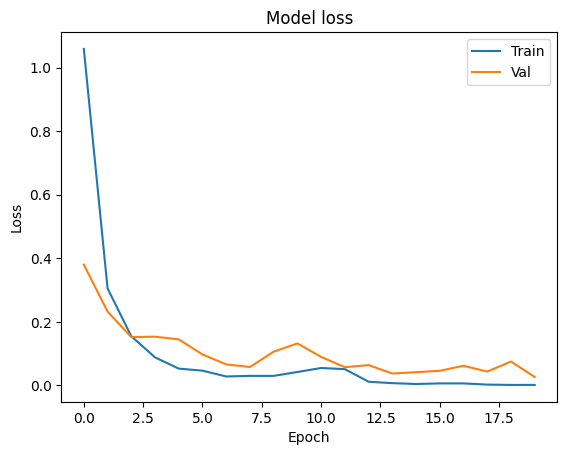

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

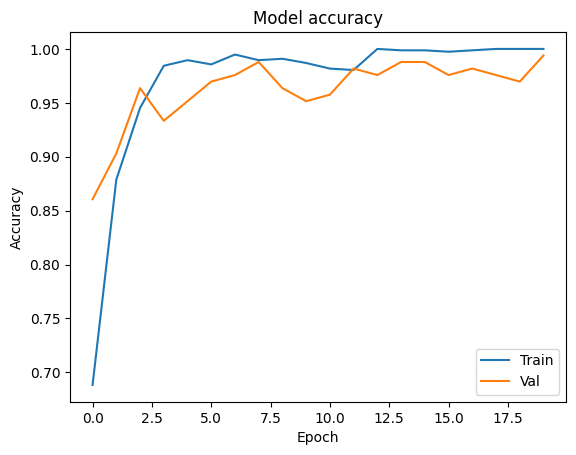

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()